# Interaction coupling

In this notebook I want to analyze if there are changes in the dependencies of interactions between residues. As we have seen, there is not a set of interactions which stability identifies a large enough set of biased mutants. I think that interaction couopling is a good structural metric because:
* It is posible to find meaninfull correlations with signaling profile despite stabilities not changing
* It can be linked to protein communication

## Appraoch

1. Compute interaction coupling
    1. Read contact tables
    2. Unify diferent types of interactions between the same two residues.
    3. stablish a distance threshold between interactions based on a criteria
    4. compute a score (problably chisquared) acounting for the independency of the two variables
2. Search for differences between wt-like and biased

In [138]:
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import MDAnalysis as mda
import scipy
import nglview as nv
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('/home/amorales/Documents/projects/bias_2')

## Residue proximity matrix

Because of the huge combinatorial numbers of all the interactions in the protein, it is unpractical (and does not make sense) to consider all possible correlations in the protein. For this reason I will apply distance threshold for considering the correlation. In this step there are many variables to take into consideration that can affect the result of the analysis. For the moment I will consider interactions that have at least a pair of residues within a distance below a threshold. Distances will be computed from the crystal of the inactive CB2

In [101]:
inactive_cb2 = mda.Universe('data/raw/cb2_inactive.pdb')

In [113]:
alpha_carbons = inactive_cb2.select_atoms('name CA and (prop resid < 1000)')

In [119]:
distance = scipy.spatial.distance.cdist(alpha_carbons.positions, alpha_carbons.positions)

In [121]:
distance.shape

(291, 291)

<AxesSubplot:>

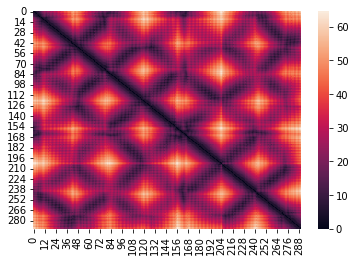

In [122]:
sns.heatmap(distance)

In [127]:
distance_df = pd.DataFrame(distance, index=alpha_carbons.resids, columns=alpha_carbons.resids)

In [129]:
distances = distance_df.values[np.triu_indices(distance_df.shape[0], k=1)]

<AxesSubplot:ylabel='Count'>

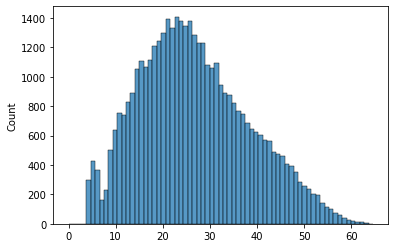

In [130]:
sns.histplot(distances)

## Compute interaction coupling

In [11]:
def parse_contact_table(path):
    
    

TypeError: object of type 'int' has no len()

In [78]:
for path in glob('data/interim/contacts/*/*contacts.tsv'):
    print(path)

data/interim/contacts/109/1contacts.tsv
data/interim/contacts/109/2contacts.tsv
data/interim/contacts/109/3contacts.tsv
data/interim/contacts/109/4contacts.tsv
data/interim/contacts/109/5contacts.tsv
data/interim/contacts/112/1contacts.tsv
data/interim/contacts/112/2contacts.tsv
data/interim/contacts/112/3contacts.tsv
data/interim/contacts/112/4contacts.tsv
data/interim/contacts/112/5contacts.tsv
data/interim/contacts/117/1contacts.tsv
data/interim/contacts/117/2contacts.tsv
data/interim/contacts/117/3contacts.tsv
data/interim/contacts/117/4contacts.tsv
data/interim/contacts/117/5contacts.tsv
data/interim/contacts/119/1contacts.tsv
data/interim/contacts/119/2contacts.tsv
data/interim/contacts/119/3contacts.tsv
data/interim/contacts/119/4contacts.tsv
data/interim/contacts/119/5contacts.tsv
data/interim/contacts/121/1contacts.tsv
data/interim/contacts/121/2contacts.tsv
data/interim/contacts/121/3contacts.tsv
data/interim/contacts/121/4contacts.tsv
data/interim/contacts/121/5contacts.tsv


In [79]:
path = 'data/interim/contacts/33/1contacts.tsv'

In [80]:
# Load contact dataframe
with open(path, 'r') as file:
    
    for i in range(2):
        next(file)
    
    file_list = []
    for line in file:
        line = line.strip()
        line = line.split('\t')
        line = line + [''] * (6-len(line))
        
        # print(line)
        file_list.append(line)
        
contact_df = pd.DataFrame(file_list, columns=['frame', 'type', 'atom1', 'atom2', 'atom3', 'atom4'])


In [81]:
contact_df

,frame,type,atom1,atom2,atom3,atom4
0,0,sb,A:ARG:131:NH2,A:ASP:130:OD2,,
1,0,sb,B:ARG:242:NH2,B:GLU:305:OE2,,
2,0,sb,B:ARG:238:NH1,B:ASP:240:OD1,,
3,0,sb,B:ARG:242:NH1,B:GLU:305:OE2,,
4,0,sb,A:ASP:101:OD2,A:LYS:109:NZ,,
...,...,...,...,...,...,...
1002900,399,wb2,A:LYS:103:NZ,A:SER:19:OG,S:TIP3:1913:OH2,S:TIP3:1746:OH2
1002901,399,wb2,A:LYS:103:NZ,A:SER:19:N,S:TIP3:1913:OH2,S:TIP3:1746:OH2
1002902,399,wb,A:ARG:147:NH1,A:ARG:66:NH2,S:TIP3:7198:OH2,
1002903,399,wb2,A:ASP:24:OD2,A:LYS:23:NZ,S:TIP3:5607:OH2,S:TIP3:4149:OH2


In [82]:
# simplify interactions
res1 = [a.split(':')[2] for a in contact_df.atom1]

In [83]:
res2 = [a.split(':')[2] for a in contact_df.atom2]
# Replace residue 1 for lig
res2 = ['lig' if r == '1' else r for r in res2]

In [84]:
# Build contact name from residues
contact = [f'{r1}-{r2}' for r1, r2 in zip(res1, res2)]

In [85]:
contact_df['contact'] = contact

In [86]:
# Remove non essential columns
contact_df = contact_df[['frame', 'contact']]

In [87]:
contact_df['val'] = 1

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
contact_df = contact_df.drop_duplicates()

In [89]:
contact_df['frame'] = contact_df['frame'].astype(int)

In [90]:
contact_df = pd.pivot(contact_df, index='frame', columns='contact', values='val')

In [91]:
contact_df = contact_df.fillna(0)

In [92]:
contact_df

contact,101-100,101-102,101-103,101-105,101-106,101-109,101-19,101-21,101-22,101-90,...,99-19,99-21,99-22,99-23,99-26,99-94,99-95,99-96,99-97,99-98
frame,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
396,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
397,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [93]:
corr_mat = contact_df.corr(method='spearman')

In [94]:
corr_mat = corr_mat.fillna(0)

In [95]:
corr_mat

contact,101-100,101-102,101-103,101-105,101-106,101-109,101-19,101-21,101-22,101-90,...,99-19,99-21,99-22,99-23,99-26,99-94,99-95,99-96,99-97,99-98
contact,,,,,,,,,,,,,,,,,,,,,
101-100,1.000000,-0.091501,0.048048,0.085956,-0.069269,0.001418,-0.062867,0.049071,-0.036501,-0.051685,...,0.020256,0.104850,0.057694,-0.004070,0.073088,0.070263,-0.038579,-0.019896,-0.076905,-0.037881
101-102,-0.091501,1.000000,0.025987,-0.107664,0.104911,0.047296,0.010171,0.026781,0.193599,0.218196,...,-0.102115,-0.100086,0.125646,-0.022715,0.089957,-0.100229,-0.009445,0.081161,0.185302,0.001937
101-103,0.048048,0.025987,1.000000,0.085042,0.012821,-0.056756,-0.103228,-0.024049,-0.121471,-0.241962,...,0.003603,0.035824,-0.028210,-0.008885,0.036719,0.167344,-0.022875,0.013497,-0.001060,-0.051614
101-105,0.085956,-0.107664,0.085042,1.000000,-0.220335,0.037648,-0.283038,-0.026588,-0.189558,-0.326427,...,-0.005432,-0.128845,-0.303039,-0.137811,-0.089307,0.191733,0.010346,0.000814,-0.061019,-0.106017
101-106,-0.069269,0.104911,0.012821,-0.220335,1.000000,0.068107,0.186294,-0.048099,0.175640,0.232465,...,-0.108095,0.014074,0.161601,0.076013,0.022031,-0.166119,-0.030024,-0.044539,0.041323,0.116131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-94,0.070263,-0.100229,0.167344,0.191733,-0.166119,-0.086369,-0.268662,-0.041089,-0.300907,-0.449858,...,0.091195,-0.093032,-0.248821,-0.155978,-0.138018,1.000000,0.174056,-0.021398,0.185833,-0.111326
99-95,-0.038579,-0.009445,-0.022875,0.010346,-0.030024,0.010127,0.018707,-0.007152,-0.077616,-0.111248,...,0.144654,0.063920,0.016538,-0.073099,-0.024023,0.174056,1.000000,-0.021674,0.065225,-0.018707
99-96,-0.019896,0.081161,0.013497,0.000814,-0.044539,-0.228243,-0.001358,-0.007595,0.120620,0.055726,...,0.134659,0.000539,-0.033346,-0.077632,-0.025513,-0.021398,-0.021674,1.000000,0.024652,0.103239


In [140]:
corr_mat

contact,101-100,101-102,101-103,101-105,101-106,101-109,101-19,101-21,101-22,101-90,...,99-19,99-21,99-22,99-23,99-26,99-94,99-95,99-96,99-97,99-98
contact,,,,,,,,,,,,,,,,,,,,,
101-100,1.000000,-0.091501,0.048048,0.085956,-0.069269,0.001418,-0.062867,0.049071,-0.036501,-0.051685,...,0.020256,0.104850,0.057694,-0.004070,0.073088,0.070263,-0.038579,-0.019896,-0.076905,-0.037881
101-102,-0.091501,1.000000,0.025987,-0.107664,0.104911,0.047296,0.010171,0.026781,0.193599,0.218196,...,-0.102115,-0.100086,0.125646,-0.022715,0.089957,-0.100229,-0.009445,0.081161,0.185302,0.001937
101-103,0.048048,0.025987,1.000000,0.085042,0.012821,-0.056756,-0.103228,-0.024049,-0.121471,-0.241962,...,0.003603,0.035824,-0.028210,-0.008885,0.036719,0.167344,-0.022875,0.013497,-0.001060,-0.051614
101-105,0.085956,-0.107664,0.085042,1.000000,-0.220335,0.037648,-0.283038,-0.026588,-0.189558,-0.326427,...,-0.005432,-0.128845,-0.303039,-0.137811,-0.089307,0.191733,0.010346,0.000814,-0.061019,-0.106017
101-106,-0.069269,0.104911,0.012821,-0.220335,1.000000,0.068107,0.186294,-0.048099,0.175640,0.232465,...,-0.108095,0.014074,0.161601,0.076013,0.022031,-0.166119,-0.030024,-0.044539,0.041323,0.116131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-94,0.070263,-0.100229,0.167344,0.191733,-0.166119,-0.086369,-0.268662,-0.041089,-0.300907,-0.449858,...,0.091195,-0.093032,-0.248821,-0.155978,-0.138018,1.000000,0.174056,-0.021398,0.185833,-0.111326
99-95,-0.038579,-0.009445,-0.022875,0.010346,-0.030024,0.010127,0.018707,-0.007152,-0.077616,-0.111248,...,0.144654,0.063920,0.016538,-0.073099,-0.024023,0.174056,1.000000,-0.021674,0.065225,-0.018707
99-96,-0.019896,0.081161,0.013497,0.000814,-0.044539,-0.228243,-0.001358,-0.007595,0.120620,0.055726,...,0.134659,0.000539,-0.033346,-0.077632,-0.025513,-0.021398,-0.021674,1.000000,0.024652,0.103239


In [96]:
corr_values = corr_mat.values[np.triu_indices(2047, k=1)]

In [97]:
corr_values.size

2094081

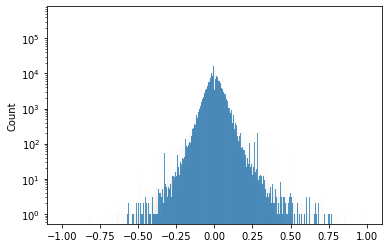

In [139]:
sns.histplot(corr_values)
plt.yscale('log')

In [99]:
corr_values.max()

1.0